# <center><font color=Green>Etude du prix de l'immobilier en Californie</font></center>

- [Import des librairies](#1)
- [Import des données](#2)
- [Exploration des données](#3)
- [Pre-processing et choix du modèle](#4)
- [Gestion des paramètres et réduction de l'overfitting](#5)
- [Modélisation & évaluation](#6)

## <a id='1'><font color="Green"><center>Import des librairies</center></font></a>

In [1]:
#base
import numpy as np
import pandas as pd

#data
from sklearn import datasets

#viz
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#preprocessing
from sklearn.model_selection import *
from sklearn.preprocessing import *

#modelisation
from lazypredict.Supervised import LazyRegressor
# C:\Anaconda\Lib\site-packages\lazypredict\Supervised.py à remplacer par celui fourni dans le dossier Github au 10/03/2022
# Sinon, séance de debug à prévoir
from lightgbm import LGBMRegressor

#evaluation
from sklearn.metrics import *

## <a id='2'><font color="Green"><center>Import des données</center></font></a>

Affichage du dataset

In [2]:
data = datasets.fetch_california_housing()
print(dir(data))

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']


In [3]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

info supplémentaire : "The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000)."
<br>source : https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

In [4]:
dataset, dataset["Price"] = pd.DataFrame(columns=data["feature_names"], data=data.data), data.target 
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.33,41.00,6.98,1.02,322.00,2.56,37.88,-122.23,4.53
1,8.30,21.00,6.24,0.97,2401.00,2.11,37.86,-122.22,3.58
2,7.26,52.00,8.29,1.07,496.00,2.80,37.85,-122.24,3.52
3,5.64,52.00,5.82,1.07,558.00,2.55,37.85,-122.25,3.41
4,3.85,52.00,6.28,1.08,565.00,2.18,37.85,-122.25,3.42


## <a id='3'><font color="Green"><center>Exploration des données</center></font></a>

In [5]:
dataset.describe()     #sert à afficher un maximum de stats d'un seul coup.

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


In [6]:
dataset.dtypes #vérification du type de données
#Toutes les données sont numériques, il n'y a donc pas de transformation à effectuer.

MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
Price         float64
dtype: object

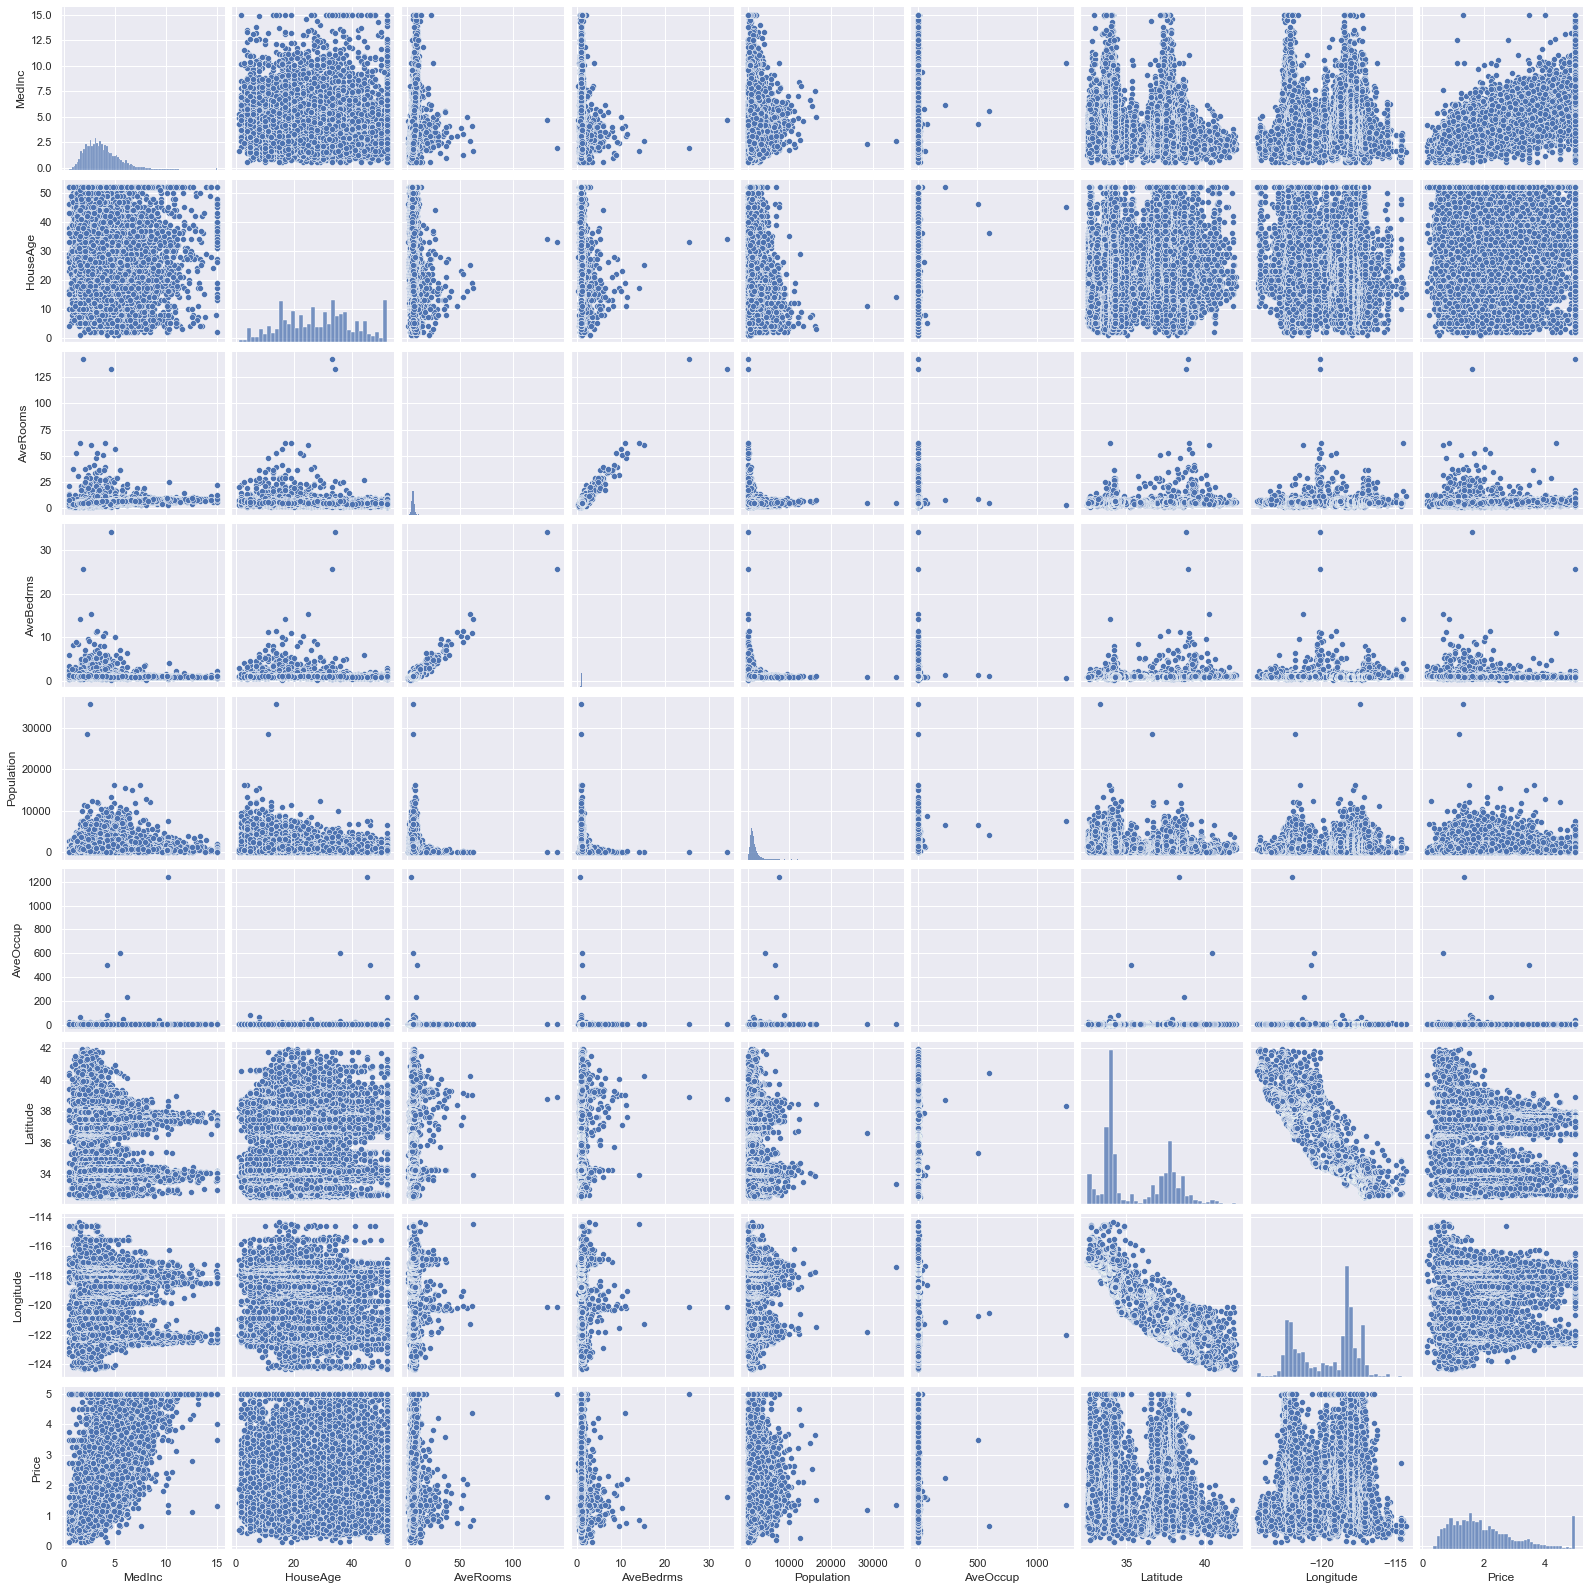

In [7]:
sns.pairplot(dataset)

Il semble y avoir une corrélation entre le revenu médian de la zone et le prix des biens
<br>Les nuages de points entre Longitude et Latitude dessinent une carte partielle de la Californie
<br>Les distributions ne sont pas normales (pas de StandardScaler)

#### Vérification de l'influence des caractéristiques sur le prix

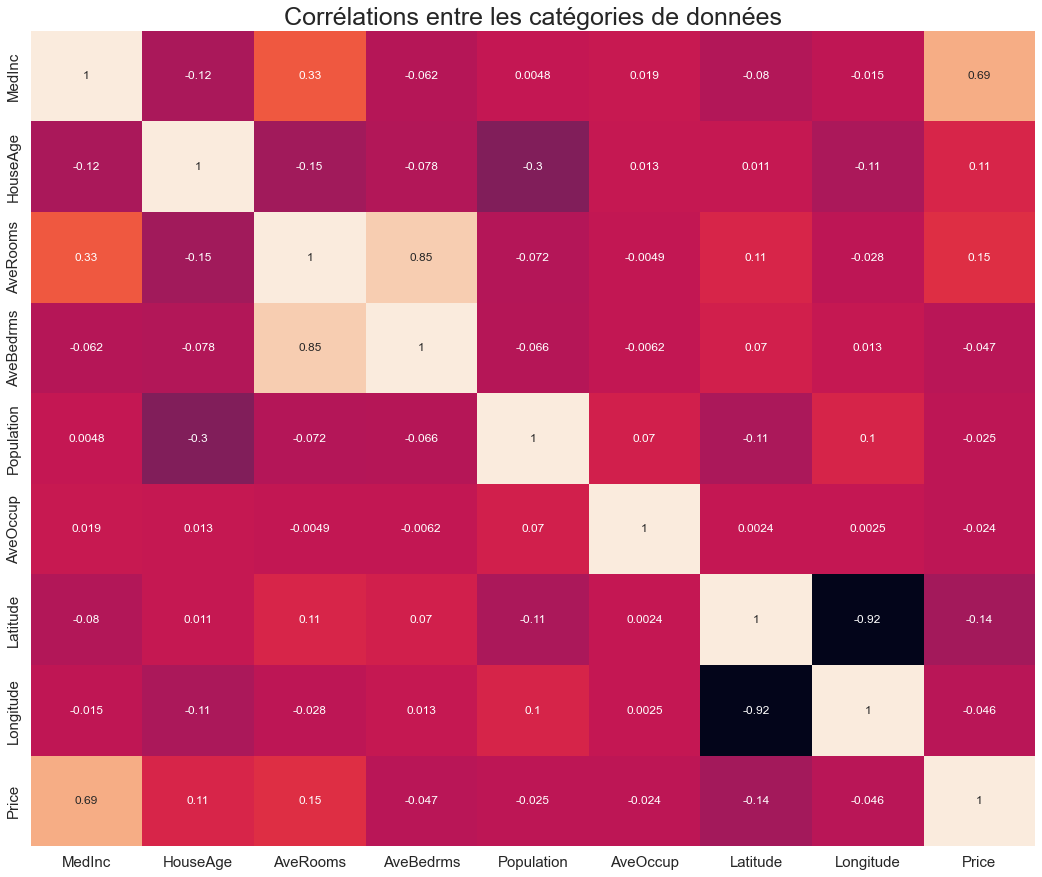

In [8]:
plt.figure(figsize=(18,15))        #définition de la taille totale du plot
sns.heatmap(dataset.corr(), annot=True, cbar=False)        #seaborn.type_de_plot(dataframe.correlation())
plt.title("Corrélations entre les catégories de données", fontsize=25)  #paramètres du titre affiché
plt.tick_params(labelsize=15)      #réglages graphiques des barres d'infos
plt.show()                         #montrer le plot

Lien entre le prix des biens et le revenu médian d'une zone confirmé

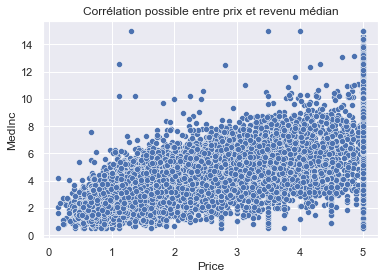

In [9]:
sns.scatterplot(x=dataset.Price,y=dataset.MedInc)
plt.title("Corrélation possible entre prix et revenu médian")
plt.ylabel("MedInc")
plt.xlabel("Price")
plt.show()

### Recherche des outliers

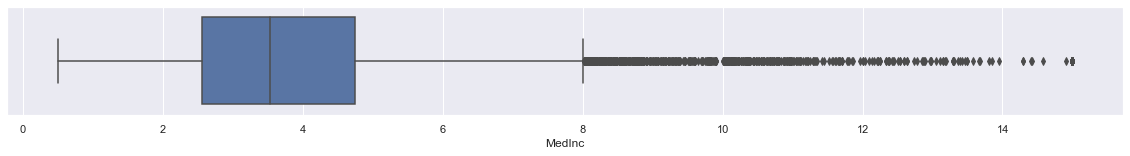

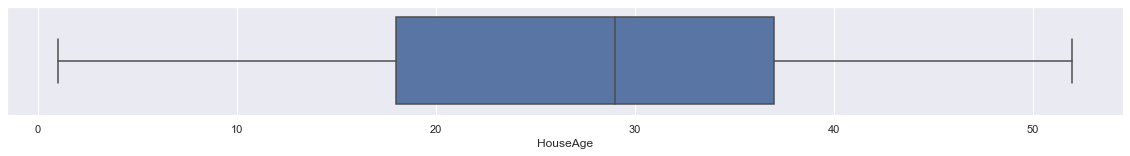

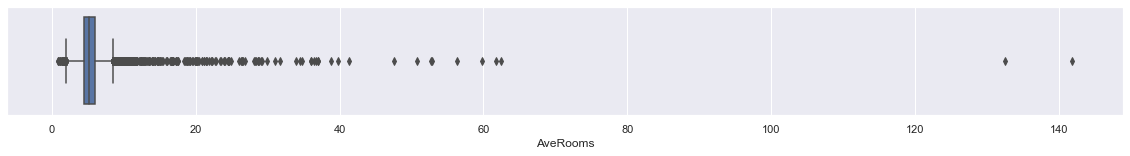

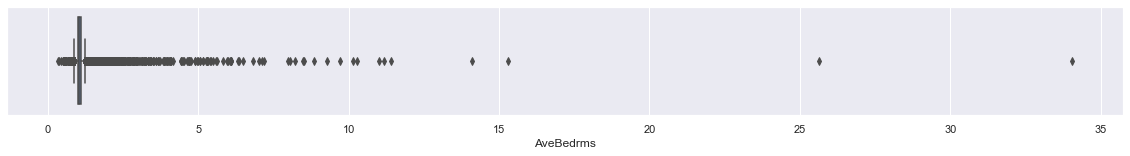

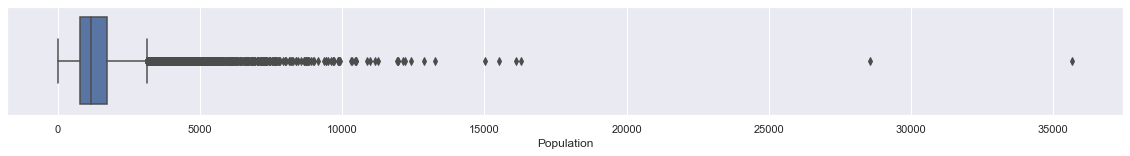

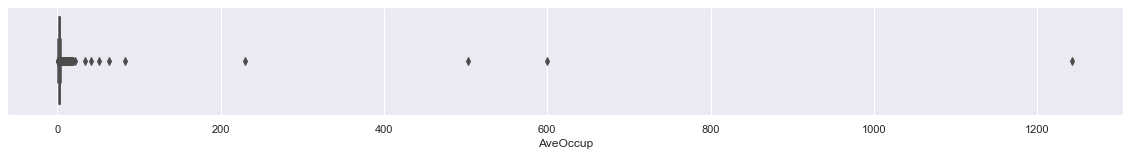

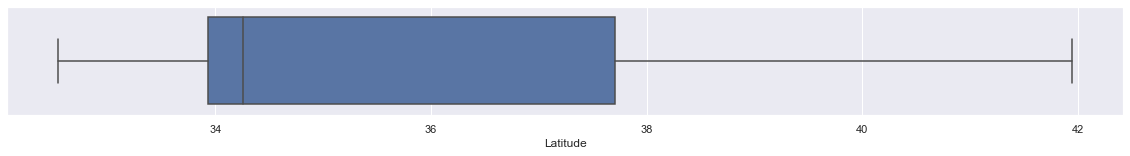

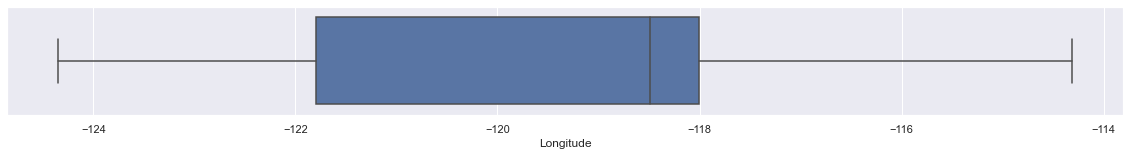

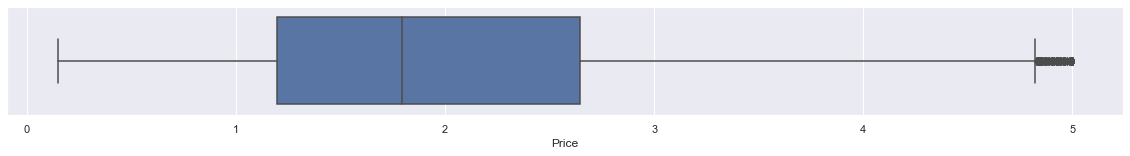

In [10]:
for col in dataset:
    plt.figure(figsize=(20,2))
    sns.boxplot(dataset[col])
    plt.show()

Population : beaucoup de données atypiques, qui correspondent aux grandes métropoles.
<br>MedInc : Californie = San Francisco = Silicon Valley et autres lieux de richesse.
<br>AveRooms : Los Angeles = Hollywood et autres berceaux à villas. Il y a peut-être quand même des données aberrantes.
<br>AveRooms : Idem AveRooms, jusqu'à 34 chambres, c'est beaucoup, même pour une villa.
<br>AveOccup : Plus de 200 occupants dans un logement, c'est loin d'être standard
<br>On va tester les données complètes, on enlèvera les outliers si le modèle n'est pas assez performant

## <a id='4'><font color="Green"><center>Pre-processing et choix du modèle</center></font></a>
### Sur données non standardisées

In [11]:
#récupération des données sans target
X = dataset.iloc[:, 0:-1]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.33,41.00,6.98,1.02,322.00,2.56,37.88,-122.23
1,8.30,21.00,6.24,0.97,2401.00,2.11,37.86,-122.22
2,7.26,52.00,8.29,1.07,496.00,2.80,37.85,-122.24
3,5.64,52.00,5.82,1.07,558.00,2.55,37.85,-122.25
4,3.85,52.00,6.28,1.08,565.00,2.18,37.85,-122.25


In [12]:
#récupération de la target
y = dataset["Price"]
y.head()

0   4.53
1   3.58
2   3.52
3   3.41
4   3.42
Name: Price, dtype: float64

In [13]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

#test de différents modèles pour trouver le plus adapté
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
#fit sur les données
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

#affichage des résultats
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:42<00:00,  2.44s/it]

                               R-Squared  RMSE  Time Taken
Model                                                     
LGBMRegressor                       0.84  0.47        0.08
HistGradientBoostingRegressor       0.84  0.47        0.38
XGBRegressor                        0.84  0.47        0.52
RandomForestRegressor               0.81  0.50        6.91
ExtraTreesRegressor                 0.81  0.50        2.93
BaggingRegressor                    0.79  0.53        0.73
MLPRegressor                        0.78  0.54        6.79
GradientBoostingRegressor           0.78  0.54        2.36
NuSVR                               0.74  0.59       15.20
SVR                                 0.73  0.60       12.94
KNeighborsRegressor                 0.69  0.65        0.29
DecisionTreeRegressor               0.65  0.69        0.13
LinearRegression                    0.60  0.73        0.02
LassoLarsIC                         0.60  0.73        0.01
Lars                                0.60  0.73        0.

Le modèle LGBMRegressor est le plus performant ici, autant en termes de metrics que de temps de traitement
### Sur données standardisées

In [14]:
#standardisation des données sans target
df_x_stand = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns, index=dataset.index)

#réunification avec la target pour visualisation
df_full_stand = df_x_stand.copy()
df_full_stand["Price"] = dataset["Price"]
df_full_stand.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,0.54,0.78,0.04,0.02,0.01,0.00,0.57,0.21,4.53
1,0.54,0.39,0.04,0.02,0.07,0.00,0.57,0.21,3.58
2,0.47,1.00,0.05,0.02,0.01,0.00,0.56,0.21,3.52
3,0.35,1.00,0.04,0.02,0.02,0.00,0.56,0.21,3.41
4,0.23,1.00,0.04,0.02,0.02,0.00,0.56,0.21,3.42


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_full_stand.iloc[:, 0:-1], df_full_stand["Price"],
                                                    train_size=0.8, random_state=12)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:44<00:00,  2.49s/it]

                               R-Squared  RMSE  Time Taken
Model                                                     
LGBMRegressor                       0.85  0.45        0.08
HistGradientBoostingRegressor       0.85  0.46        0.72
XGBRegressor                        0.84  0.47        0.49
ExtraTreesRegressor                 0.82  0.49        2.92
RandomForestRegressor               0.82  0.50        6.91
GradientBoostingRegressor           0.80  0.53        2.37
MLPRegressor                        0.80  0.53        7.73
BaggingRegressor                    0.79  0.53        0.72
NuSVR                               0.75  0.59       15.07
SVR                                 0.74  0.59       13.13
KNeighborsRegressor                 0.70  0.64        0.28
DecisionTreeRegressor               0.65  0.69        0.13
Lars                                0.62  0.73        0.02
LassoLarsIC                         0.62  0.73        0.02
TransformedTargetRegressor          0.62  0.73        0.

Sur le LGBM (modèle de prédilection), le R² est augmenté et le RMSE diminué. C'est donc une amélioration par rapport aux données non standardisées.
### Sur données non standardisées, outliers supprimés

MedInc > 8
<br>AveRooms > 40
<br>AveOccup > 200

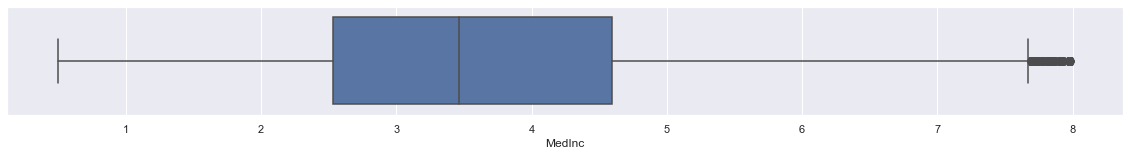

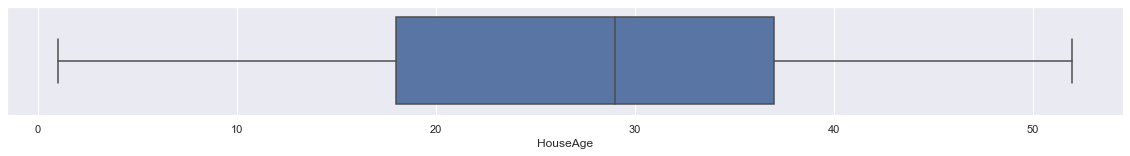

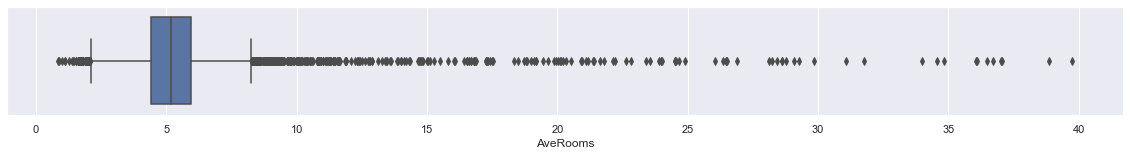

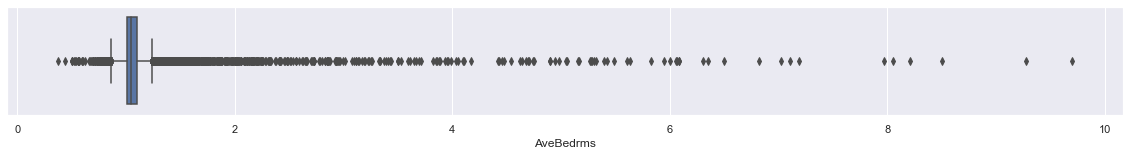

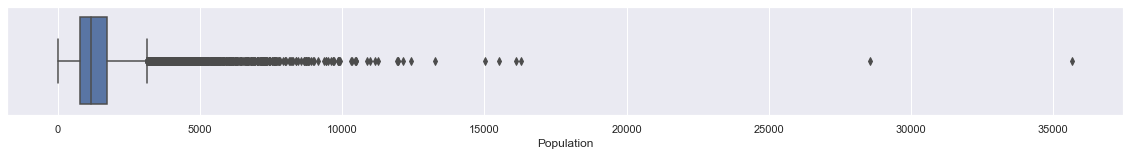

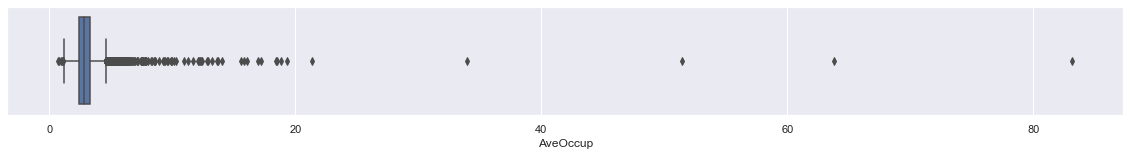

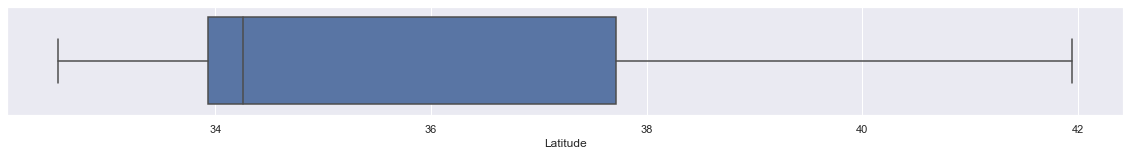

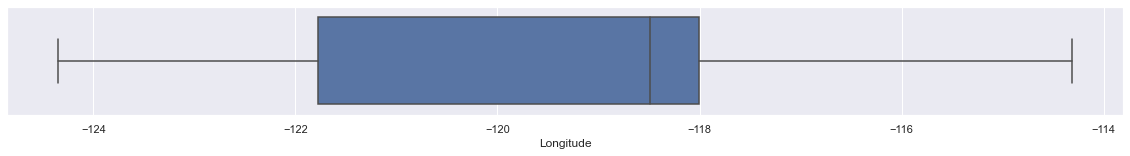

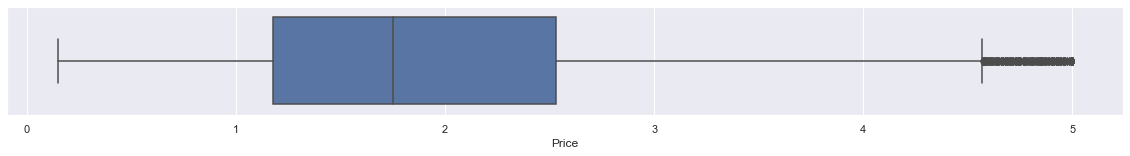

In [16]:
df = dataset.copy()
df = df[df["MedInc"] < 8] #suppression des biens dont le quartier est trop riche (bye bye Hollywood)
df = df[df["AveRooms"] < 40] #suppression des énormes villas
df = df[df["AveOccup"] < 200] #suppression des biens extrêmement occupés

#on vérifie que les filtres ont bien été appliqués
for col in df:
    plt.figure(figsize=(20,2))
    sns.boxplot(df[col])
    plt.show()

In [17]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
2,7.26,52.00,8.29,1.07,496.00,2.80,37.85,-122.24,3.52
3,5.64,52.00,5.82,1.07,558.00,2.55,37.85,-122.25,3.41
4,3.85,52.00,6.28,1.08,565.00,2.18,37.85,-122.25,3.42
5,4.04,52.00,4.76,1.10,413.00,2.14,37.85,-122.25,2.70
6,3.66,52.00,4.93,0.95,1094.00,2.13,37.84,-122.25,2.99


In [18]:
#split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df["Price"], train_size=0.8)

#test de différents modèles pour trouver le plus adapté
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
#fit sur les données
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

#affichage des résultats
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:37<00:00,  2.33s/it]

                               R-Squared  RMSE  Time Taken
Model                                                     
HistGradientBoostingRegressor       0.81  0.46        0.37
LGBMRegressor                       0.81  0.46        0.08
XGBRegressor                        0.81  0.46        0.48
ExtraTreesRegressor                 0.79  0.49        2.84
RandomForestRegressor               0.78  0.49        6.54
GradientBoostingRegressor           0.76  0.52        2.27
BaggingRegressor                    0.76  0.52        0.69
MLPRegressor                        0.76  0.52        8.37
NuSVR                               0.74  0.54       14.41
SVR                                 0.74  0.54       12.36
KNeighborsRegressor                 0.69  0.59        0.22
LassoCV                             0.57  0.69        0.09
ElasticNetCV                        0.57  0.69        0.10
RidgeCV                             0.57  0.69        0.00
BayesianRidge                       0.57  0.69        0.

Le R² est diminué et le RMSE augmenté par rapport aux tests précédents. C'est donc moins bien.
### Sur données standardisées, outliers supprimés

MedInc > 8
<br>AveRooms > 40
<br>AveOccup > 200

In [19]:
#standardisation des données sans target
df_x_stand = pd.DataFrame(MinMaxScaler().fit_transform(df.iloc[:, 0:-1]), columns=df.iloc[:, 0:-1].columns, index=df.index)

#réunification avec la target pour visualisation
df_full_stand = df_x_stand.copy()
df_full_stand["Price"] = df["Price"]
df_full_stand.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
2,0.90,1.00,0.19,0.07,0.01,0.03,0.56,0.21,3.52
3,0.69,1.00,0.13,0.07,0.02,0.02,0.56,0.21,3.41
4,0.45,1.00,0.14,0.08,0.02,0.02,0.56,0.21,3.42
5,0.47,1.00,0.10,0.08,0.01,0.02,0.56,0.21,2.70
6,0.42,1.00,0.11,0.06,0.03,0.02,0.56,0.21,2.99


In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_x_stand, df["Price"],
                                                    train_size=0.8, random_state=12)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:37<00:00,  2.33s/it]

                               R-Squared  RMSE  Time Taken
Model                                                     
HistGradientBoostingRegressor       0.80  0.47        0.36
LGBMRegressor                       0.80  0.47        0.08
XGBRegressor                        0.80  0.47        0.48
ExtraTreesRegressor                 0.77  0.51        2.81
RandomForestRegressor               0.77  0.51        6.58
MLPRegressor                        0.74  0.54        8.36
GradientBoostingRegressor           0.74  0.54        2.26
BaggingRegressor                    0.73  0.55        0.68
NuSVR                               0.72  0.56       14.90
SVR                                 0.72  0.56       12.27
KNeighborsRegressor                 0.68  0.60        0.20
HuberRegressor                      0.58  0.69        0.05
SGDRegressor                        0.58  0.69        0.03
LinearSVR                           0.57  0.69        0.50
ElasticNetCV                        0.57  0.69        0.

C'est notre moins bonne modélisation.

## <a id='5'><font color="Green"><center>Gestion des paramètres et réduction de l'overfitting</center></font></a>

### Remise en place des données à utiliser

In [21]:
#standardisation des données sans target
df_x_stand = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns, index=dataset.index)

#réunification avec la target
df_full_stand = df_x_stand.copy()
df_full_stand["Price"] = dataset["Price"]
df_full_stand.head()

#split
X_train, X_test, y_train, y_test = train_test_split(df_full_stand.iloc[:, 0:-1], df_full_stand["Price"],
                                                    train_size=0.8, random_state=12)

### Sélection des paramètres et tests

Quelques paramètres choisis :

- <b>boosting_type</b> <i>(str, optional (default='gbdt'))</i> – ‘<b>gbdt</b>’, traditional Gradient Boosting Decision Tree. ‘<b>dart</b>’, Dropouts meet Multiple Additive Regression Trees. ‘<b>goss</b>’, Gradient-based One-Side Sampling. ‘<b>rf</b>’, Random Forest.

- <b>num_leaves</b> <i>(int, optional (default=31))</i> – Maximum tree leaves for base learners.

- <b>max_depth</b> <i>(int, optional (default=-1))</i> – Maximum tree depth for base learners, <=0 means no limit.

- <b>learning_rate</b> <i>(float, optional (default=0.1))</i> – Boosting learning rate. You can use callbacks parameter of fit method to shrink/adapt learning rate in training using reset_parameter callback. Note, that this will ignore the learning_rate argument in training.

- <b>n_estimators</b> <i>(int, optional (default=100))</i> – Number of boosted trees to fit.

- <b>min_child_samples</b> <i>(int, optional (default=20))</i> – Minimum number of data needed in a child (leaf).

- <b>reg_alpha</b> <i>(float, optional (default=0.))</i> – L1 regularization term on weights.

- <b>reg_lambda</b> <i>(float, optional (default=0.))</i> – L2 regularization term on weights.

,train_scores,test_scores,difference
0,0.89,0.83,0.05
1,0.79,0.76,0.03
2,0.89,0.83,0.05
3,NaN,NaN,NaN


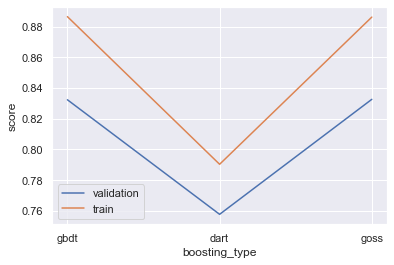

In [22]:
boosting_type = list(('gbdt', 'dart', 'goss', 'rf')) #rf ne fonctionne pas sur ces données

for k in boosting_type:
    train_scores, test_scores = validation_curve(LGBMRegressor(boosting_type=k), 
                                                 X_train, y_train,
                                                 param_name="boosting_type",
                                                 scoring="r2",                                          
                                                 param_range=boosting_type,
                                                 cv=5)

plt.plot(boosting_type, test_scores.mean(axis=1), label = 'validation')
plt.plot(boosting_type, train_scores.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('boosting_type')
plt.legend();

df_results = pd.DataFrame()
df_results["train_scores"] = pd.DataFrame(train_scores.mean(axis=1))
df_results["test_scores"] = pd.DataFrame(test_scores.mean(axis=1))
df_results["difference"] = df_results["train_scores"] - df_results["test_scores"]
df_results

Meilleurs scores pour gbdt et goss mais overfitting limité sur dart.
<br>Nous allons rester sur l'option par défaut = Gradient Boosting Decision Tree

,train_scores,test_scores,difference
5,0.79,0.78,0.01
6,0.80,0.79,0.01
7,0.81,0.79,0.02
8,0.82,0.80,0.02
9,0.82,0.80,0.02
10,0.83,0.81,0.02
11,0.84,0.81,0.02
12,0.84,0.81,0.03
13,0.84,0.82,0.03
14,0.85,0.82,0.03


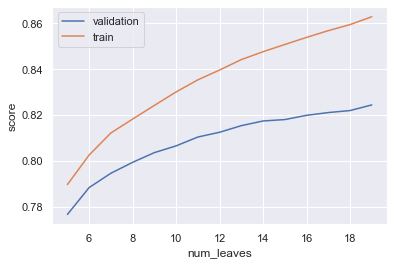

In [23]:
num_leaves = list(range(5,20,1))

for k in num_leaves:
    train_scores, test_scores = validation_curve(LGBMRegressor(num_leaves=k), 
                                                 X_train, y_train,
                                                 param_name="num_leaves",
                                                 scoring="r2",                                          
                                                 param_range=num_leaves,
                                                 cv=5)

plt.plot(num_leaves, test_scores.mean(axis=1), label = 'validation')
plt.plot(num_leaves, train_scores.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('num_leaves')
plt.legend();

del df_results
df_results = pd.DataFrame()
df_results["train_scores"] = pd.DataFrame(train_scores.mean(axis=1))
df_results["test_scores"] = pd.DataFrame(test_scores.mean(axis=1))
df_results["difference"] = df_results["train_scores"] - df_results["test_scores"]
df_results.index = num_leaves
df_results

num_leaves = 6

,train_scores,test_scores,difference
6,0.88,0.82,0.05
8,0.88,0.83,0.05
10,0.89,0.83,0.05
12,0.89,0.83,0.05
14,0.89,0.83,0.05
16,0.89,0.83,0.05
18,0.89,0.83,0.05


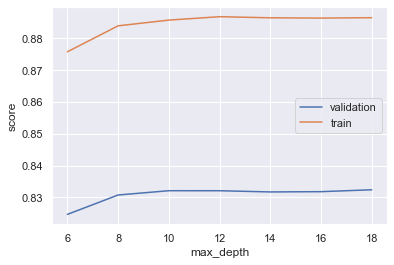

In [24]:
max_depth = list(range(6,20,2))

for k in max_depth:
    train_scores, test_scores = validation_curve(LGBMRegressor(max_depth=k), 
                                                 X_train, y_train,
                                                 param_name="max_depth",
                                                 scoring="r2",                                          
                                                 param_range=max_depth,
                                                 cv=5)

plt.plot(max_depth, test_scores.mean(axis=1), label = 'validation')
plt.plot(max_depth, train_scores.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('max_depth')
plt.legend();

del df_results
df_results = pd.DataFrame()
df_results["train_scores"] = pd.DataFrame(train_scores.mean(axis=1))
df_results["test_scores"] = pd.DataFrame(test_scores.mean(axis=1))
df_results["difference"] = df_results["train_scores"] - df_results["test_scores"]
df_results.index = max_depth
df_results

max_depth = 10

,train_scores,test_scores,difference
0.01,0.62,0.61,0.01
0.02,0.76,0.74,0.02
0.03,0.81,0.79,0.03
0.04,0.84,0.81,0.03
0.05,0.85,0.82,0.04
0.06,0.86,0.82,0.04
0.07,0.87,0.83,0.04
0.08,0.88,0.83,0.05
0.09,0.88,0.83,0.05
0.10,0.89,0.83,0.05


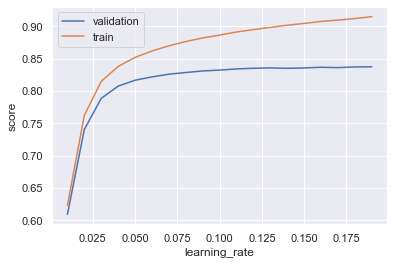

In [25]:
learning_rate = list(np.arange(0.01,0.2,0.01))

for k in learning_rate:
    train_scores, test_scores = validation_curve(LGBMRegressor(learning_rate=k), 
                                                 X_train, y_train,
                                                 param_name="learning_rate",
                                                 scoring="r2",                                          
                                                 param_range=learning_rate,
                                                 cv=5)

plt.plot(learning_rate, test_scores.mean(axis=1), label = 'validation')
plt.plot(learning_rate, train_scores.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('learning_rate')
plt.legend();

del df_results
df_results = pd.DataFrame()
df_results["train_scores"] = pd.DataFrame(train_scores.mean(axis=1))
df_results["test_scores"] = pd.DataFrame(test_scores.mean(axis=1))
df_results["difference"] = df_results["train_scores"] - df_results["test_scores"]
df_results.index = learning_rate
df_results

learning_rate = 0.04 (équilibre entre bon score et overfitting)

,train_scores,test_scores,difference
10,0.63,0.62,0.01
20,0.76,0.74,0.02
30,0.82,0.79,0.03
40,0.84,0.81,0.03
50,0.85,0.82,0.04
60,0.86,0.82,0.04
70,0.87,0.83,0.04
80,0.88,0.83,0.05
90,0.88,0.83,0.05


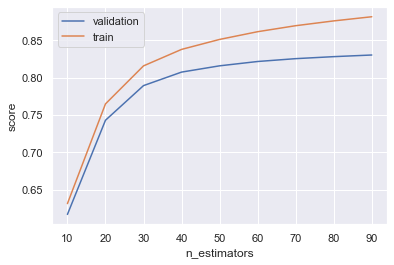

In [26]:
n_estimators = list(range(10,100,10))

for k in n_estimators:
    train_scores, test_scores = validation_curve(LGBMRegressor(n_estimators=k), 
                                                 X_train, y_train,
                                                 param_name="n_estimators",
                                                 scoring="r2",                                          
                                                 param_range=n_estimators,
                                                 cv=5)

plt.plot(n_estimators, test_scores.mean(axis=1), label = 'validation')
plt.plot(n_estimators, train_scores.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('n_estimators')
plt.legend();

del df_results
df_results = pd.DataFrame()
df_results["train_scores"] = pd.DataFrame(train_scores.mean(axis=1))
df_results["test_scores"] = pd.DataFrame(test_scores.mean(axis=1))
df_results["difference"] = df_results["train_scores"] - df_results["test_scores"]
df_results.index = n_estimators
df_results

n_estimators = 40 (idem)

,train_scores,test_scores,difference
10,0.89,0.83,0.06
20,0.89,0.83,0.05
30,0.88,0.83,0.05
40,0.88,0.83,0.05
50,0.88,0.83,0.05
60,0.88,0.83,0.05
70,0.88,0.83,0.05
80,0.87,0.83,0.04
90,0.87,0.83,0.04
100,0.87,0.83,0.04


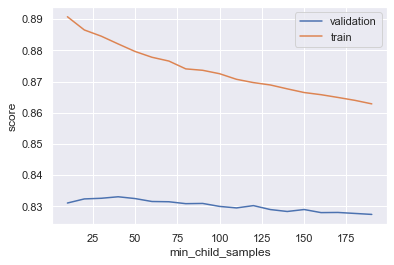

In [27]:
min_child_samples = list(range(10,200,10))

for k in min_child_samples:
    train_scores, test_scores = validation_curve(LGBMRegressor(min_child_samples=k), 
                                                 X_train, y_train,
                                                 param_name="min_child_samples",
                                                 scoring="r2",                                          
                                                 param_range=min_child_samples,
                                                 cv=5)

plt.plot(min_child_samples, test_scores.mean(axis=1), label = 'validation')
plt.plot(min_child_samples, train_scores.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('min_child_samples')
plt.legend();

del df_results
df_results = pd.DataFrame()
df_results["train_scores"] = pd.DataFrame(train_scores.mean(axis=1))
df_results["test_scores"] = pd.DataFrame(test_scores.mean(axis=1))
df_results["difference"] = df_results["train_scores"] - df_results["test_scores"]
df_results.index = min_child_samples
df_results

min_child_samples = 80

,train_scores,test_scores,difference
0.01,0.89,0.83,0.05
0.02,0.89,0.83,0.05
0.03,0.89,0.83,0.05
0.04,0.89,0.83,0.05
0.05,0.89,0.83,0.05
0.06,0.89,0.83,0.05
0.07,0.89,0.83,0.05
0.08,0.89,0.83,0.05
0.09,0.89,0.83,0.05
0.10,0.89,0.83,0.05


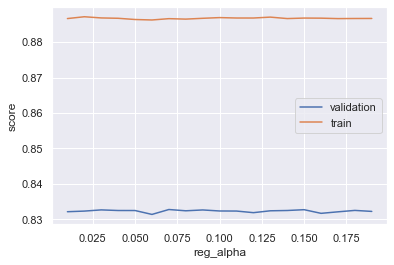

In [28]:
reg_alpha = list(np.arange(0.01,0.2,0.01))

for k in reg_alpha:
    train_scores, test_scores = validation_curve(LGBMRegressor(reg_alpha=k), 
                                                 X_train, y_train,
                                                 param_name="reg_alpha",
                                                 scoring="r2",                                          
                                                 param_range=reg_alpha,
                                                 cv=5)

plt.plot(reg_alpha, test_scores.mean(axis=1), label = 'validation')
plt.plot(reg_alpha, train_scores.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('reg_alpha')
plt.legend();

del df_results
df_results = pd.DataFrame()
df_results["train_scores"] = pd.DataFrame(train_scores.mean(axis=1))
df_results["test_scores"] = pd.DataFrame(test_scores.mean(axis=1))
df_results["difference"] = df_results["train_scores"] - df_results["test_scores"]
df_results.index = reg_alpha
df_results

reg_alpha = default (changement inutile)

,train_scores,test_scores,difference
0.01,0.89,0.83,0.05
0.02,0.89,0.83,0.05
0.03,0.89,0.83,0.05
0.04,0.89,0.83,0.05
0.05,0.89,0.83,0.05
0.06,0.89,0.83,0.05
0.07,0.89,0.83,0.05
0.08,0.89,0.83,0.05
0.09,0.89,0.83,0.05
0.10,0.89,0.83,0.05


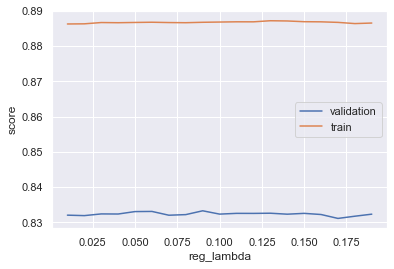

In [29]:
reg_lambda = list(np.arange(0.01,0.2,0.01))

for k in reg_lambda:
    train_scores, test_scores = validation_curve(LGBMRegressor(reg_lambda=k), 
                                                 X_train, y_train,
                                                 param_name="reg_lambda",
                                                 scoring="r2",                                          
                                                 param_range=reg_lambda,
                                                 cv=5)

plt.plot(reg_lambda, test_scores.mean(axis=1), label = 'validation')
plt.plot(reg_lambda, train_scores.mean(axis=1), label = 'train')

plt.ylabel('score')
plt.xlabel('reg_lambda')
plt.legend();

del df_results
df_results = pd.DataFrame()
df_results["train_scores"] = pd.DataFrame(train_scores.mean(axis=1))
df_results["test_scores"] = pd.DataFrame(test_scores.mean(axis=1))
df_results["difference"] = df_results["train_scores"] - df_results["test_scores"]
df_results.index = reg_lambda
df_results

reg_lambda = default (changement inutile)

## <a id='6'><font color="Green"><center>Modélisation & évaluation</center></font></a>

In [30]:
#création du modèle avec paramètres choisis
reg = LGBMRegressor(num_leaves=6, max_depth=10, learning_rate=0.04, n_estimators=40, min_child_samples=80)
#ajustement aux données d'entrainement
reg.fit(X_train, y_train)
#prédiction sur les données de test
y_pred = reg.predict(X_test)

#évaluation
print('r2 score: %.2f'% r2_score(y_test, y_pred))
print('Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))

r2 score: 0.60
Mean squared error: 0.55


Scores faibles

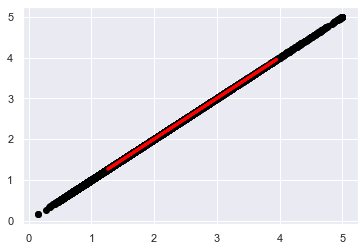

In [31]:
# Plot des résultats
plt.scatter(y_test, y_test, color='black') #données réelles
plt.plot(y_pred, y_pred, color='red', linewidth=3); #données prédites

Mais belle courbe (!)

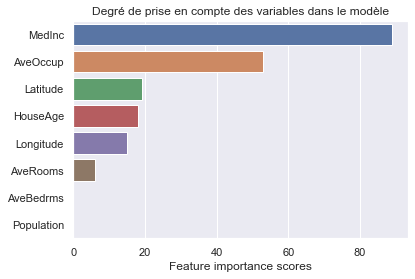

In [32]:
#affichage des scores d'importance
feature_imp = pd.Series(reg.feature_importances_, index=X.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel("Feature importance scores")
plt.title("Degré de prise en compte des variables dans le modèle")
plt.show()

Comme prévu dans l'analyse, c'est le revenu moyen de la zone qui a le plus fortement influencé le modèle
<br>Celui-ci est moyen, dans le sens où le R² est un peu trop faible et le MSE trop élevé.
<br>Cette expérimentation s'arrête ici, même s'il est possible d'améliorer ce modèle ou bien d'en créer un autre en deep learning.